Click Capture to take image


<IPython.core.display.Javascript object>

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


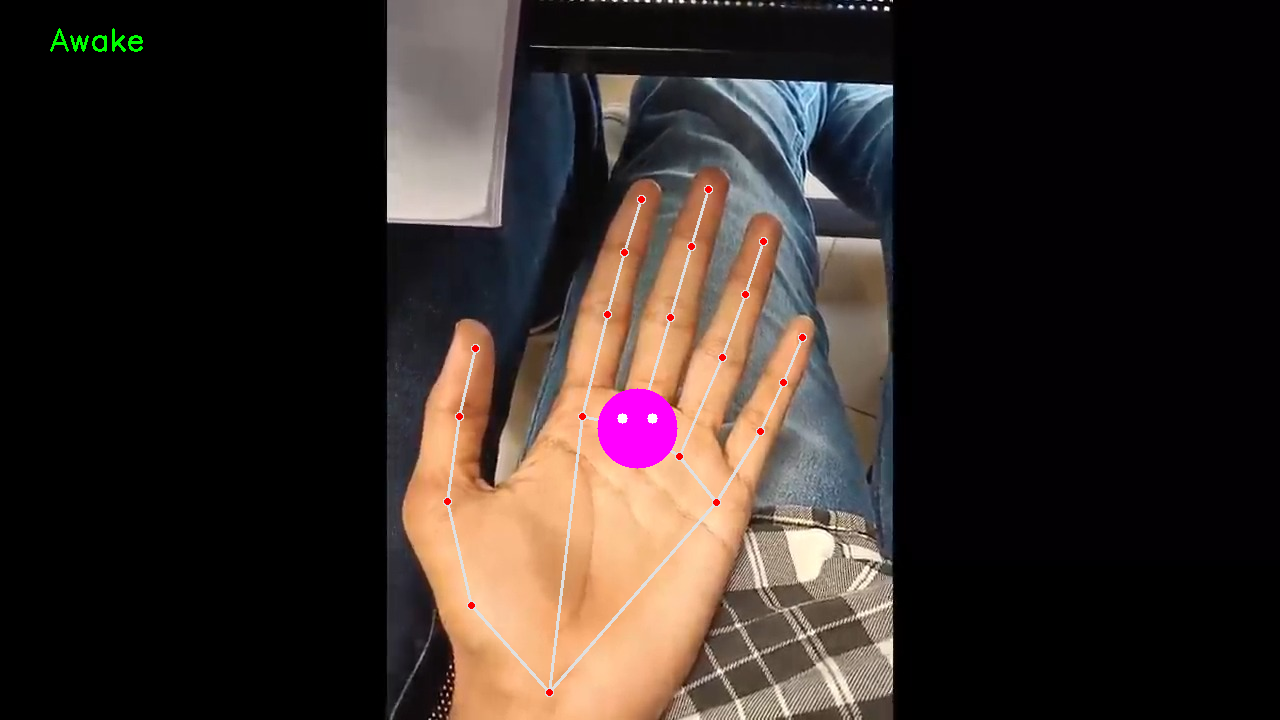

Press ENTER to continue or type 'q' to quit: 
Click Capture to take image


<IPython.core.display.Javascript object>

Press ENTER to continue or type 'q' to quit: q


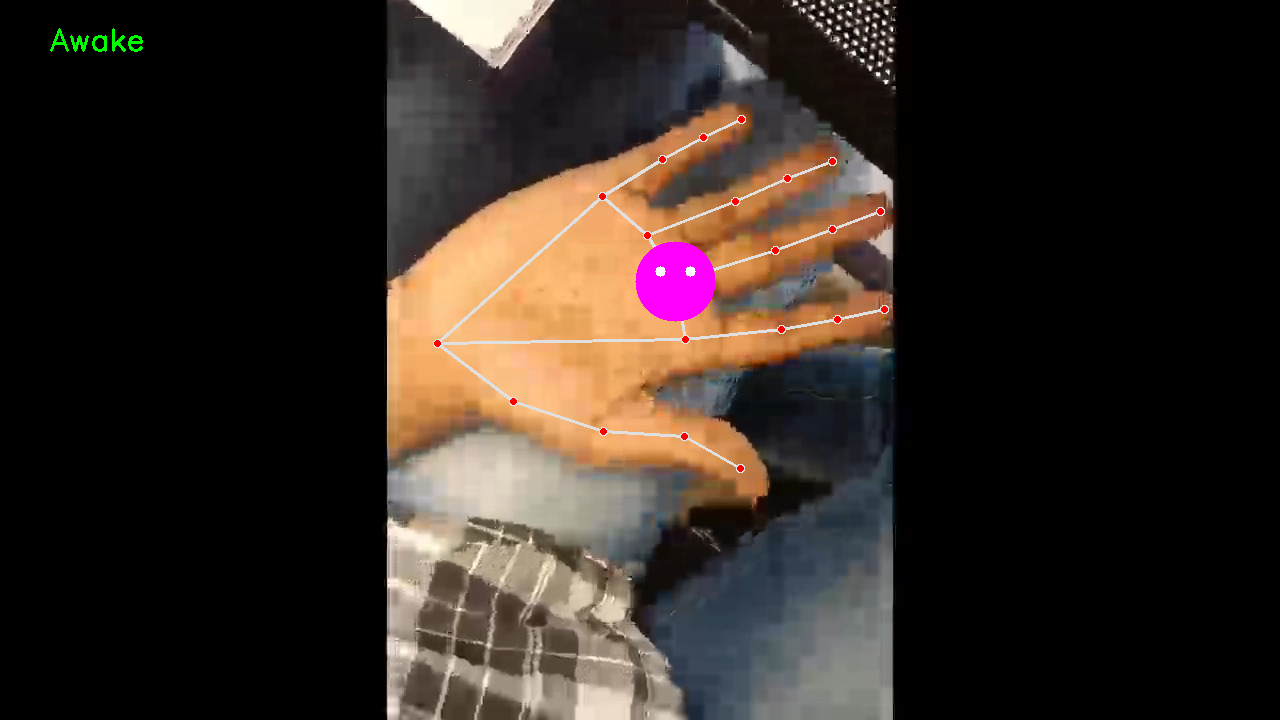

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import base64
import mediapipe as mp

# -------------------------------
# Webcam Capture Function
# -------------------------------
def take_photo():

    js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      stream.getVideoTracks()[0].stop();
      div.remove();

      return canvas.toDataURL('image/jpeg');
    }
    takePhoto();
    ''')

    display(js)
    data = eval_js('takePhoto()')
    binary = base64.b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(img, cv2.IMREAD_COLOR)


# -------------------------------
# MediaPipe Setup
# -------------------------------
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
mp_draw = mp.solutions.drawing_utils


# -------------------------------
# Main Loop
# -------------------------------
while True:

    print("Click Capture to take image")

    frame = take_photo()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:

            mp_draw.draw_landmarks(
                frame,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)

            # Palm center
            x = int(hand_landmarks.landmark[9].x * frame.shape[1])
            y = int(hand_landmarks.landmark[9].y * frame.shape[0])

            # Puppet face
            cv2.circle(frame, (x, y), 40, (255,0,255), -1)
            cv2.circle(frame, (x-15, y-10), 5, (255,255,255), -1)
            cv2.circle(frame, (x+15, y-10), 5, (255,255,255), -1)

            # Gesture detection
            tip = hand_landmarks.landmark[8].y
            base = hand_landmarks.landmark[6].y

            if tip > base:
                cv2.putText(frame, "Sleeping",
                            (50,50),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,0,255), 2)
            else:
                cv2.putText(frame, "Awake",
                            (50,50),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1, (0,255,0), 2)

    cv2_imshow(frame)

    stop = input("Press ENTER to continue or type 'q' to quit: ")
    if stop.lower() == 'q':
        break


<IPython.core.display.Javascript object>

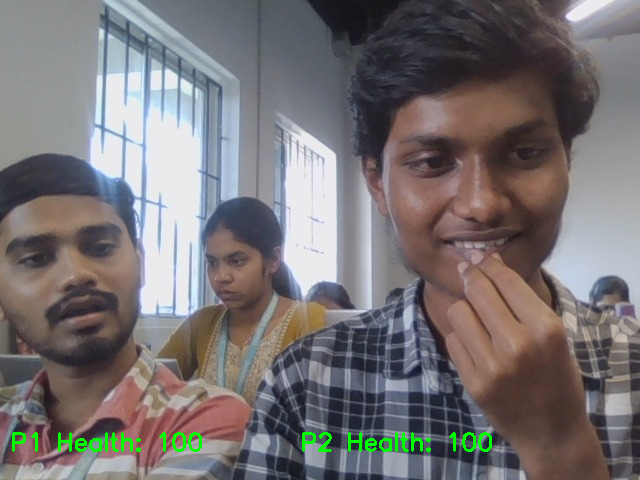

Press ENTER to continue or type 'q' to quit: q


In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import base64

def take_photo():
    js = Javascript('''
        async function takePhoto() {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);

          stream.getVideoTracks()[0].stop();
          div.remove();
          return canvas.toDataURL('image/jpeg');
        }
        takePhoto();
    ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = base64.b64decode(data.split(',')[1])
    img = np.frombuffer(binary, dtype=np.uint8)
    return cv2.imdecode(img, cv2.IMREAD_COLOR)


# -------------------------------
# ARUCO SETUP
# -------------------------------
import cv2.aruco as aruco

p1_health = 100
p2_health = 100

aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

# -------------------------------
# Main Loop
# -------------------------------
while True:

    frame = take_photo()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    corners, ids, _ = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if ids is not None:

        attacked_left = False
        attacked_right = False

        for i in range(len(ids)):
            c = corners[i][0]
            center_x = int(c[:, 0].mean())

            if center_x < frame.shape[1] // 2:
                attacked_left = True
            else:
                attacked_right = True

        if attacked_left:
            p2_health -= 5
            p2_health = max(0, p2_health)

        if attacked_right:
            p1_health -= 5
            p1_health = max(0, p1_health)

        aruco.drawDetectedMarkers(frame, corners)

    # Show health
    cv2.putText(frame, f"P1 Health: {p1_health}",
                (10,450),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0,255,0), 2)

    cv2.putText(frame, f"P2 Health: {p2_health}",
                (300,450),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8, (0,255,0), 2)

    cv2_imshow(frame)

    stop = input("Press ENTER to continue or type 'q' to quit: ")
    if stop.lower() == 'q':
        break
